In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = ':/root/.mujoco/mujoco200/bin'
# os.environ['LD_PRELOAD'] = ':'
import numpy as np
import robosuite as suite
from robosuite.utils.mjcf_utils import postprocess_model_xml

In [2]:
import os
import h5py
import argparse
import random

In [3]:
demo_path = '/home/ar4451/Data/RoboTurkPilot/bins-full/'
hdf5_path = "/home/ar4451/Data/RoboTurkPilot/bins-full/demo.hdf5"
f = h5py.File(hdf5_path, "r")
env_name = f["data"].attrs["env"]
demos = list(f["data"].keys())

In [4]:
env = suite.make(
        env_name,
        has_renderer=False,
        ignore_done=True,
        use_camera_obs=False,
        gripper_visualization=True,
        reward_shaping=True,
        control_freq=100,
    )
env2 = suite.make(
        env_name,
        has_renderer=False,
        ignore_done=True,
        use_camera_obs=False,
        gripper_visualization=True,
        reward_shaping=True,
        control_freq=100,
    )

In [5]:
import tensorflow as tf

tf_model = tf.keras.models.load_model('/home/ar4451/tf/il')
indirect_data = True

2023-05-11 02:13:11.609244: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 02:13:13.584594: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 02:13:18.002512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 02:13:18.004928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 02:13:28.976444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
rewards = []
rewards2 = []
for i in range(1):
    ep = random.choice(demos)

    # Loading XML Data for Environment to match simulated environment
    model_file = f["data/{}".format(ep)].attrs["model_file"]
    model_path = os.path.join(demo_path, "models", model_file)
    with open(model_path, "r") as model_f:
        model_xml = model_f.read()

        
    # Environment Creation/Reset
    env.reset()
    env2.reset()
    xml = postprocess_model_xml(model_xml)
    env.reset_from_xml_string(xml)
    env2.reset_from_xml_string(xml)
    env.sim.reset()
    env2.sim.reset()

    # Loading the initial states
    states = f["data/{}/states".format(ep)][()]
    env.sim.set_state_from_flattened(states[0])
    env.sim.forward()
    env2.sim.set_state_from_flattened(states[0])
    env2.sim.forward()

    # Deriving Actions and Environment Variables for Prediction
    jvels = f["data/{}/joint_velocities".format(ep)][()]
    grip_acts = f["data/{}/gripper_actuations".format(ep)][()]
    actions = np.concatenate([jvels, grip_acts], axis=1)
    num_actions = actions.shape[0]
    obs = states[0]
    ep_rewards = []
    ep_rewards2 = []
    if indirect_data:
        for j, action in enumerate(actions):
            _, reward1, done1, _  = env.step(action)
            state = env2.sim.get_state().flatten()
            state = np.array([state])
            predicted = tf_model.predict(state)
            predicted = np.squeeze(predicted)
            _, reward2, done2, _  = env2.step(predicted)
            ep_rewards.append(reward1)
            ep_rewards2.append(reward2)
            if done1 or done2:
                break
    else:
        for state, action in zip(states, actions):
            env.sim.set_state_from_flattened(state)
            env.sim.forward()
            ep_rewards.append(env.reward(action))
    rewards.append(ep_rewards)
    rewards2.append(ep_rewards2)

1/1 [==============================] - 0s 19ms/step


In [7]:
print(len(ep_rewards2))

3899


In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Rewards Achieved on Single Run of Base Model')

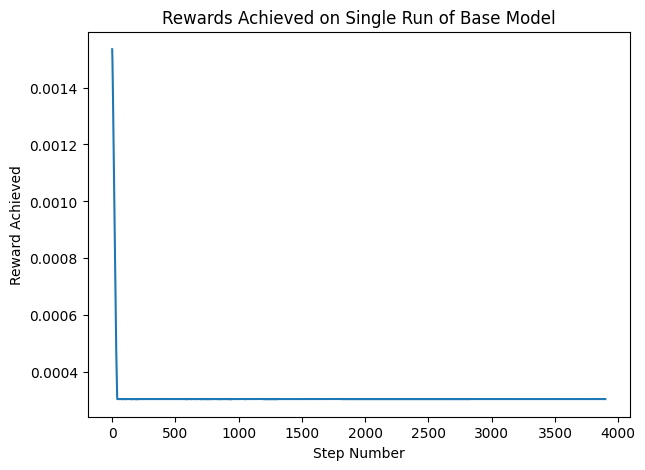

In [9]:
plt.figure(figsize=(7,5))
for reward in rewards2:
    plt.plot(reward)
plt.xlabel("Step Number")
plt.ylabel("Reward Achieved")
plt.title("Rewards Achieved on Single Run of Base Model")
# plt.savefig('/home/ar4451/BL_1_graph.png')

Text(0.5, 1.0, 'Rewards Achieved on Single Run of Imitation Learning Model')

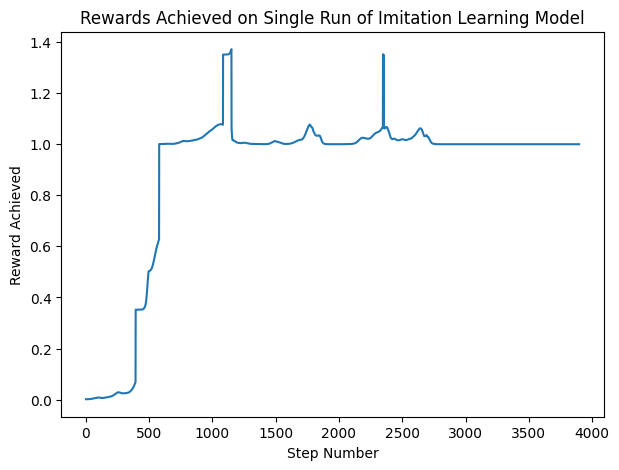

In [11]:
plt.figure(figsize=(7,5))
for reward in rewards:
    plt.plot(reward)
plt.xlabel("Step Number")
plt.ylabel("Reward Achieved")
plt.title("Rewards Achieved on Single Run of Imitation Learning Model")
# plt.savefig('/home/ar4451/IL_1_graph.png')

In [12]:
import csv

header = ['RUN', 'TYPE', 'POSITION', 'REWARD']

with open('/home/ar4451/rl_1_rewards.csv', 'w') as f2:
    writer = csv.writer(f2)
    writer.writerow(header)
    j = 1
    for reward in rewards:
        k = 0
        for elem in reward:
            row = [j, 'bins-full', k, elem]
            writer.writerow(row)
            k+=1
            if k > 5000:
                break
        j+=1